<a href="https://colab.research.google.com/github/ZPavlo/ML_projects/blob/master/object_detecion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
PATH = "/content/gdrive/My Drive"

In [0]:
import os 
from torchvision.datasets.voc import VOCDetection
import cv2
import numpy as np

class MyVOCDetection(VOCDetection):

    def __init__(self, root, image_set, download=False, transforms=None):
      super(MyVOCDetection, self).__init__(root, image_set=image_set, download=download, transforms=transforms)
      self.dim = (300, 300)

    def __getitem__(self, index):
      img, target = super().__getitem__(index)
      img = np.array(img)

      annotation = target["annotation"]
      boxes_dict = annotation["object"]
      if isinstance(boxes_dict, dict):
        boxes_dict = [boxes_dict]
      size = annotation["size"]
      size = (int(size["depth"]), int(size["height"]), int(size["width"]))
      
      boxes = []
      for box in boxes_dict:
          boxes.append([float(box["bndbox"]["xmin"]), float(box["bndbox"]["ymin"]),
                        float(box["bndbox"]["xmax"]), float(box["bndbox"]["ymax"])])
      boxes = np.array(boxes)
      if self.transform is not None:
            img, target = self.transforms(img, target)

      img = cv2.resize(img, self.dim, interpolation = cv2.INTER_AREA)
      
      boxes[:, 0] = boxes[:, 0] * (self.dim[0] / float(size[2]))
      boxes[:, 1] = boxes[:, 1] * (self.dim[1] / float(size[1]))
      boxes[:, 2] = boxes[:, 2] * (self.dim[0] / float(size[2]))
      boxes[:, 3] = boxes[:, 3] * (self.dim[1] / float(size[1]))
      
      return (img.transpose(2, 0, 1), 
              size, 
              boxes)

ROOT_PATH = os.path.join(PATH, "datasets")

train_dataset = MyVOCDetection(ROOT_PATH, image_set="train", download=False)
val_dataset = MyVOCDetection(ROOT_PATH, image_set="val", download=False)

In [0]:
BATCH_SIZE = 8

In [0]:
from torch.utils.data import DataLoader

def my_collate_fn(samples):

    images = []
    sizes = []
    boxes_batch = []

    for (img, size, boxes) in samples:
        images.append(img)
        boxes_batch.append(boxes)
        sizes.append(size)

    images = np.array(images)

    return {"img": images,
            "boxes": boxes_batch,
            "size": sizes,
            }

train_load = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                        num_workers=0, pin_memory=True, 
                        collate_fn=my_collate_fn)
val_load = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        num_workers=0, pin_memory=True)

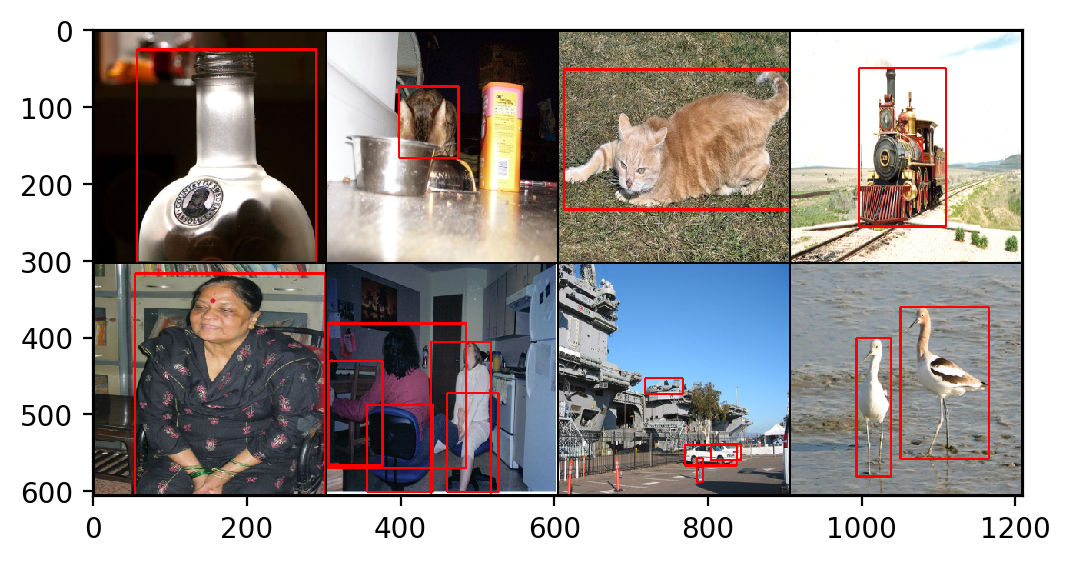

In [81]:
import torchvision.utils as utils
import torch
import matplotlib.pyplot as plt

batch = next(iter(train_load))

def draph_boxes(image, objs):

    image = np.transpose(image, (1, 2, 0))

    for box in objs:
        image = cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255,0,0), 2)

    image = np.transpose(image.get(), (2, 0, 1))
    return torch.from_numpy(image)

new_imgs = []
for i, img in enumerate(batch["img"]):
    new_imgs.append(draph_boxes(img, batch["boxes"][i]))

grid = utils.make_grid(new_imgs, 4, padding=2)
ngrid = grid.numpy()

plt.figure(dpi=200)
plt.imshow(np.transpose(ngrid, (1, 2, 0)))